<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/Kaggle_nyc_taxi_trip_duration_%ED%94%8C%EC%A0%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [80]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-duration_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-duration_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-durationsample_submission.csv')
train.shape, test.shape, submit.shape

((1458644, 11), (625134, 9), (625134, 2))

Text(0.5, 1.0, 'Distribution After log1p')

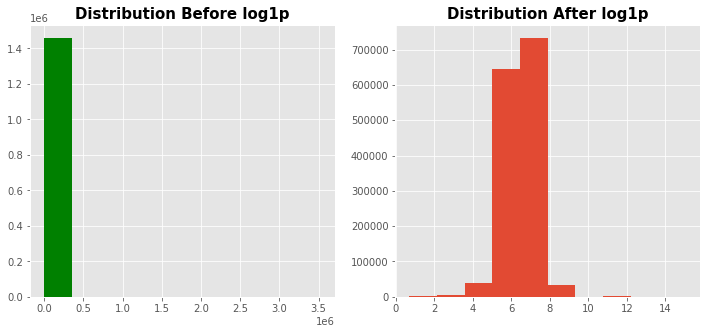

In [20]:
# target변수에 log1p를 할 것.
fig, ax = plt.subplots(1,2, figsize=(12,5))
train['trip_duration'].hist(ax=ax[0], color='green')
ax[0].set_title('Distribution Before log1p', fontsize=15, fontweight='bold')
np.log1p(train['trip_duration']).hist(ax=ax[1])
ax[1].set_title('Distribution After log1p', fontsize=15, fontweight='bold')

# 만들 columns 

1. distance(pickup_lon - dropoff_lon, pickup_lat-dropoff_lat, np.sqrt(np.square(train['dist_long']) + np.square(train['dist_lat'])))
2. clustering
3. speed(100000*train['dist'] / train['trip_duration'])  ==> test는 못 만드니까 지워야 함
4. 시계열 columns (pickup 시계열로)

---
# Feature Engineering


In [81]:
# 시계열 컬럼
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

train['month'] = train['pickup_datetime'].dt.month
train['day'] = train['pickup_datetime'].dt.day
train['hour'] = train['pickup_datetime'].dt.hour
train['minute'] = train['pickup_datetime'].dt.minute
train['weekday'] = train['pickup_datetime'].dt.weekday
train['weekend'] = train['weekday'].apply(lambda x: 1 if x in [5,6] else 0)

test['month'] = test['pickup_datetime'].dt.month
test['day'] = test['pickup_datetime'].dt.day
test['hour'] = test['pickup_datetime'].dt.hour
test['minute'] = test['pickup_datetime'].dt.minute
test['weekday'] = test['pickup_datetime'].dt.weekday
test['weekend'] = test['weekday'].apply(lambda x: 1 if x in [5,6] else 0)

In [82]:
# store_and_fwd_flag FE
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace({'N':0, 'Y':1})
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].replace({'N':0, 'Y':1})

In [83]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def feature_construct(df):
  # distance feautres
  df['dist_long'] = df['pickup_longitude'] - df['dropoff_longitude']
  df['dist_lat'] = df['pickup_latitude'] - df['dropoff_latitude']
  df['dist'] = np.sqrt(np.square(df['dist_long']) + np.square(df['dist_lat']))
  

  df['dist_long'] = np.abs(df['dist_long'])
  df['dist_lat'] = np.abs(df['dist_lat'])

  # 어디에서 어디까지 탔는가를 value_counts() ==> 구간별로 걸리는 시간(trip_duration)이 다를수도 있기 때문
  df['pickup_longitude_bin'] = np.round(df['pickup_longitude'], 3)  # 그런데 위경도가 너무 크지 않나...?
  df['pickup_latitude_bin'] = np.round(df['pickup_latitude'], 3)
  df['dropoff_longitude_bin'] = np.round(df['dropoff_longitude'], 3)
  df['dropoff_latitude_bin'] = np.round(df['dropoff_latitude'], 3)

  # bearning distance 구하기
  df['bearing_distance'] = df.apply(lambda x: calculateBearing(x['pickup_latitude_bin'], x['pickup_longitude_bin'], x['dropoff_latitude_bin'], x['dropoff_longitude_bin']), axis=1)

  return df

In [84]:
train = feature_construct(train)
test = feature_construct(test)

In [85]:
a = pd.concat([train,test]).groupby(['pickup_longitude_bin', 'pickup_latitude_bin']).size().reset_index(name='bin_valuecounts')
b = pd.concat([train,test]).groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin']).size().reset_index(name='bin_valuecounts')

train = train.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')
test = test.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')

train = train.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')
test = test.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,hour,minute,weekday,weekend,dist_long,dist_lat,dist,pickup_longitude_bin,pickup_latitude_bin,dropoff_longitude_bin,dropoff_latitude_bin,bin_valuecounts_x,bin_valuecounts_y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,14,17,24,0,0,0.017525,0.002335,0.017680,-73.982,40.768,-73.965,40.766,5256,602
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,12,0,43,6,1,0.019066,0.007412,0.020456,-73.980,40.739,-73.999,40.731,1010,394
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,19,11,35,1,0,0.026306,0.053852,0.059934,-73.979,40.764,-74.005,40.710,1132,264
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,4,6,19,32,2,0,0.002228,0.013252,0.013438,-74.010,40.720,-74.012,40.707,1190,636
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,3,26,13,30,5,1,0.000130,0.010689,0.010690,-73.973,40.793,-73.973,40.783,1482,442


In [86]:
# speed columns 이용
train['speed'] = 100000*train['dist'] / train['trip_duration']

In [87]:
a = train.groupby(['pickup_longitude_bin', 'pickup_latitude_bin'])['speed'].mean().reset_index(name='avg_speed')
b = train.groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin'])['speed'].mean().reset_index(name='avg_speed')

train = train.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')
train = train.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')

test = test.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')
test = test.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,hour,minute,weekday,weekend,dist_long,dist_lat,dist,pickup_longitude_bin,pickup_latitude_bin,dropoff_longitude_bin,dropoff_latitude_bin,bin_valuecounts_x,bin_valuecounts_y,speed,avg_speed_x,avg_speed_y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,14,17,24,0,0,0.017525,0.002335,0.017680,-73.982,40.768,-73.965,40.766,5256,602,3.885613,3.347062,3.354606
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,12,0,43,6,1,0.019066,0.007412,0.020456,-73.980,40.739,-73.999,40.731,1010,394,3.085355,3.678684,3.408484
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,19,11,35,1,0,0.026306,0.053852,0.059934,-73.979,40.764,-74.005,40.710,1132,264,2.821742,3.317220,4.552624
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,4,6,19,32,2,0,0.002228,0.013252,0.013438,-74.010,40.720,-74.012,40.707,1190,636,3.132449,4.069836,4.190553
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,3,26,13,30,5,1,0.000130,0.010689,0.010690,-73.973,40.793,-73.973,40.783,1482,442,2.457372,4.437244,4.029664


In [94]:
# clustering
from sklearn.cluster import KMeans

longi = np.vstack((train[['pickup_longitude_bin', 'pickup_latitude_bin']],
                  train[['dropoff_longitude_bin', 'dropoff_latitude_bin']],
                  test[['pickup_longitude_bin', 'pickup_latitude_bin']],
                  test[['dropoff_longitude_bin', 'dropoff_latitude_bin']]))
# Elbow method
sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=42).fit(longi)
  sse[i] = km.inertia_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Elbow method graph')

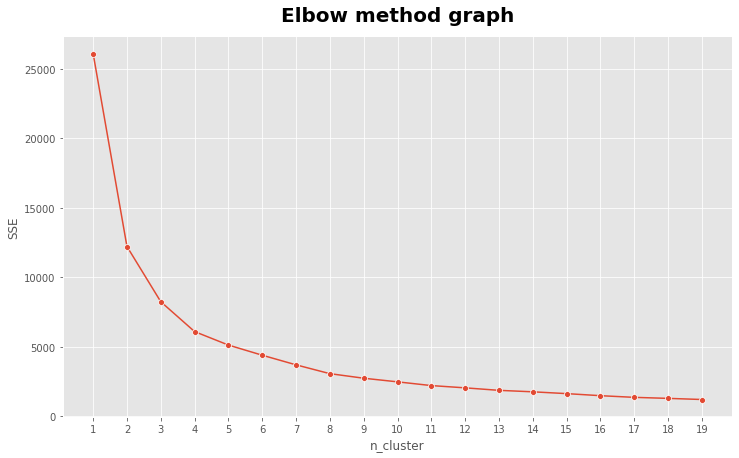

In [97]:
plt.figure(figsize=(12,7))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.ylabel('SSE')
plt.xlabel('n_cluster')
plt.xticks(pd.Series(sse).index)
plt.title('Elbow method graph', fontsize=20, pad=15, fontweight='bold')

In [107]:
# predict
km = KMeans(n_clusters=4, max_iter=1000, random_state=42).fit(longi)

train['pickup_cluster'] = km.predict(train[['pickup_longitude_bin', 'pickup_latitude_bin']])
train['dropoff_cluster'] = km.predict(train[['dropoff_longitude_bin', 'dropoff_latitude_bin']])

test['pickup_cluster'] = km.predict(test[['pickup_longitude_bin', 'pickup_latitude_bin']])
test['dropoff_cluster'] = km.predict(test[['dropoff_longitude_bin', 'dropoff_latitude_bin']])

# visualize
plt.figure(figsize=(10,8))
sns.scatterplot(x=train['pickup_longitude'], y=train['pickup_latitude'], hue=train['pickup_cluster'], data=train)
plt.xlim((-74.03, -73.75))
plt.ylim((40.63, 40.85))
plt.title('scatter map for clustering', fontsize=20, pad=20, fontweight='bold')

# Data preprocessing

In [136]:
# data split
x_train = train.drop(columns=['id', 'trip_duration', 'pickup_datetime', 'dropoff_datetime', 'speed', 'pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'])
y_train = np.log1p(train['trip_duration'])  # 타겟에 log1p 
x_test = test.drop(columns=['id', 'pickup_datetime', 'pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'])
x_train_columns, x_test_columns = x_train.columns, x_test.columns
x_train.shape, x_test.shape

((1458644, 22), (625134, 22))

In [137]:
# scaling
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

# Modeling (Catboost) - 라이브러리 설치

In [140]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 100 kB/s 
     |████████████████████████████████| 302 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 7.1 MB/s 
     |████████████████████████████████| 164 kB 53.7 MB/s 
     |████████████████████████████████| 75 kB 3.5 MB/s 
     |████████████████████████████████| 111 kB 53.1 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 141 kB 49.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=6b86619b348b71111c3cb6d65a6a844bb7111e5e81c9270d0e95f8a4e72af34b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# KFold와 STratifiedKFold로 할게요
 
 - train_test_split는 optuna용

In [155]:
import catboost
import optuna
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [156]:
cat_features = x_train.select_dtypes('object').columns

def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
kf = KFold(n_splits=7, shuffle=True, random_state=42)
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape,))
RMSLE = {}

params = {
    'iterations':study.best_params['iterations'],
    'loss_function':'RMSE',
    'task_type':"CPU",
    'eval_metric':'RMSE',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth': study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Lossguide'
}

for i, (train_index, val_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[val_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[val_index]

  model_cat = catboost.CatBoostRegressor(**params)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test) / kf.n_splits)
  val_preds = model_cat.predict(X_valid)
  RMSLE[i] = mean_squared_log_error(val_preds, Y_valid)
  print(f'{i+1}번째 RMSLE:{RMSLE[i]}')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
sns.lineplot(X_valid, Y_valid, label='True', ax=ax[0])
sns.lineplot(X_valid, val_preds, label='Preds', ax=ax[0])
ax[0].set_title('True vs Preds', fontsize=18, fontweight='bold', pad=15)

sns.lineplot(pd.Series(RMSLE).index, pd.Series(RMSLE), marker='o', ax=ax[1])
ax[1].set_title('RMSLE graph', fontsize=18, fontweight='bold', pad=15)